<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION/blob/main/Pipeline2(GFI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from matplotlib.ticker import MultipleLocator

In [2]:
data1 = pd.read_csv("GFI_dataset.csv")

# Convert Date column to datetime
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values('Date')
data1.set_index('Date', inplace=True)

print(data1.head())

                  Close         High          Low         Open
Date                                                          
2012-12-31  9091.963867  9151.554951  8999.072886  9104.232763
2013-01-01  9091.963867  9091.963867  9091.963867  9091.963867
2013-01-02  9323.318359  9325.946504  9043.767691  9151.556707
2013-01-03  9335.583984  9376.772209  9183.978625  9289.138496
2013-01-04  9049.024414  9131.399905  8955.256723  9113.873744


/tmp/ipython-input-4064079063.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data1['Date'] = pd.to_datetime(data1['Date'])


In [3]:
from statsmodels.tsa.stattools import adfuller

# Loop through each feature
for col in ["Close", "High", "Low", "Open"]:
    result = adfuller(data1[col].dropna())
    print(f"Feature: {col}")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    print("-" * 40)

Feature: Close
  ADF Statistic: -0.8927524476821448
  p-value: 0.790349769845352
----------------------------------------
Feature: High
  ADF Statistic: -1.129604601213029
  p-value: 0.7031227284341343
----------------------------------------
Feature: Low
  ADF Statistic: -1.0113363349123317
  p-value: 0.7491072102344439
----------------------------------------
Feature: Open
  ADF Statistic: -1.0917706683810122
  p-value: 0.7183424850696943
----------------------------------------


In [4]:
# Define the ADF test function
def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('-'*50)

features = data1.select_dtypes(include=[np.number]).columns

# Calculate percentage change (returns)
data_returns = data1[features].pct_change().dropna()

# Run ADF test on each feature
for col in features:
    adf_test(data_returns[col], title=f"{col} (Returns)")

Augmented Dickey-Fuller Test: Close (Returns)
ADF Statistic: -40.17952119272028
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: High (Returns)
ADF Statistic: -39.88932325419743
p-value: 0.0
--------------------------------------------------
Augmented Dickey-Fuller Test: Low (Returns)
ADF Statistic: -13.49927808718864
p-value: 2.9990343346863835e-25
--------------------------------------------------
Augmented Dickey-Fuller Test: Open (Returns)
ADF Statistic: -18.951097277075363
p-value: 0.0
--------------------------------------------------


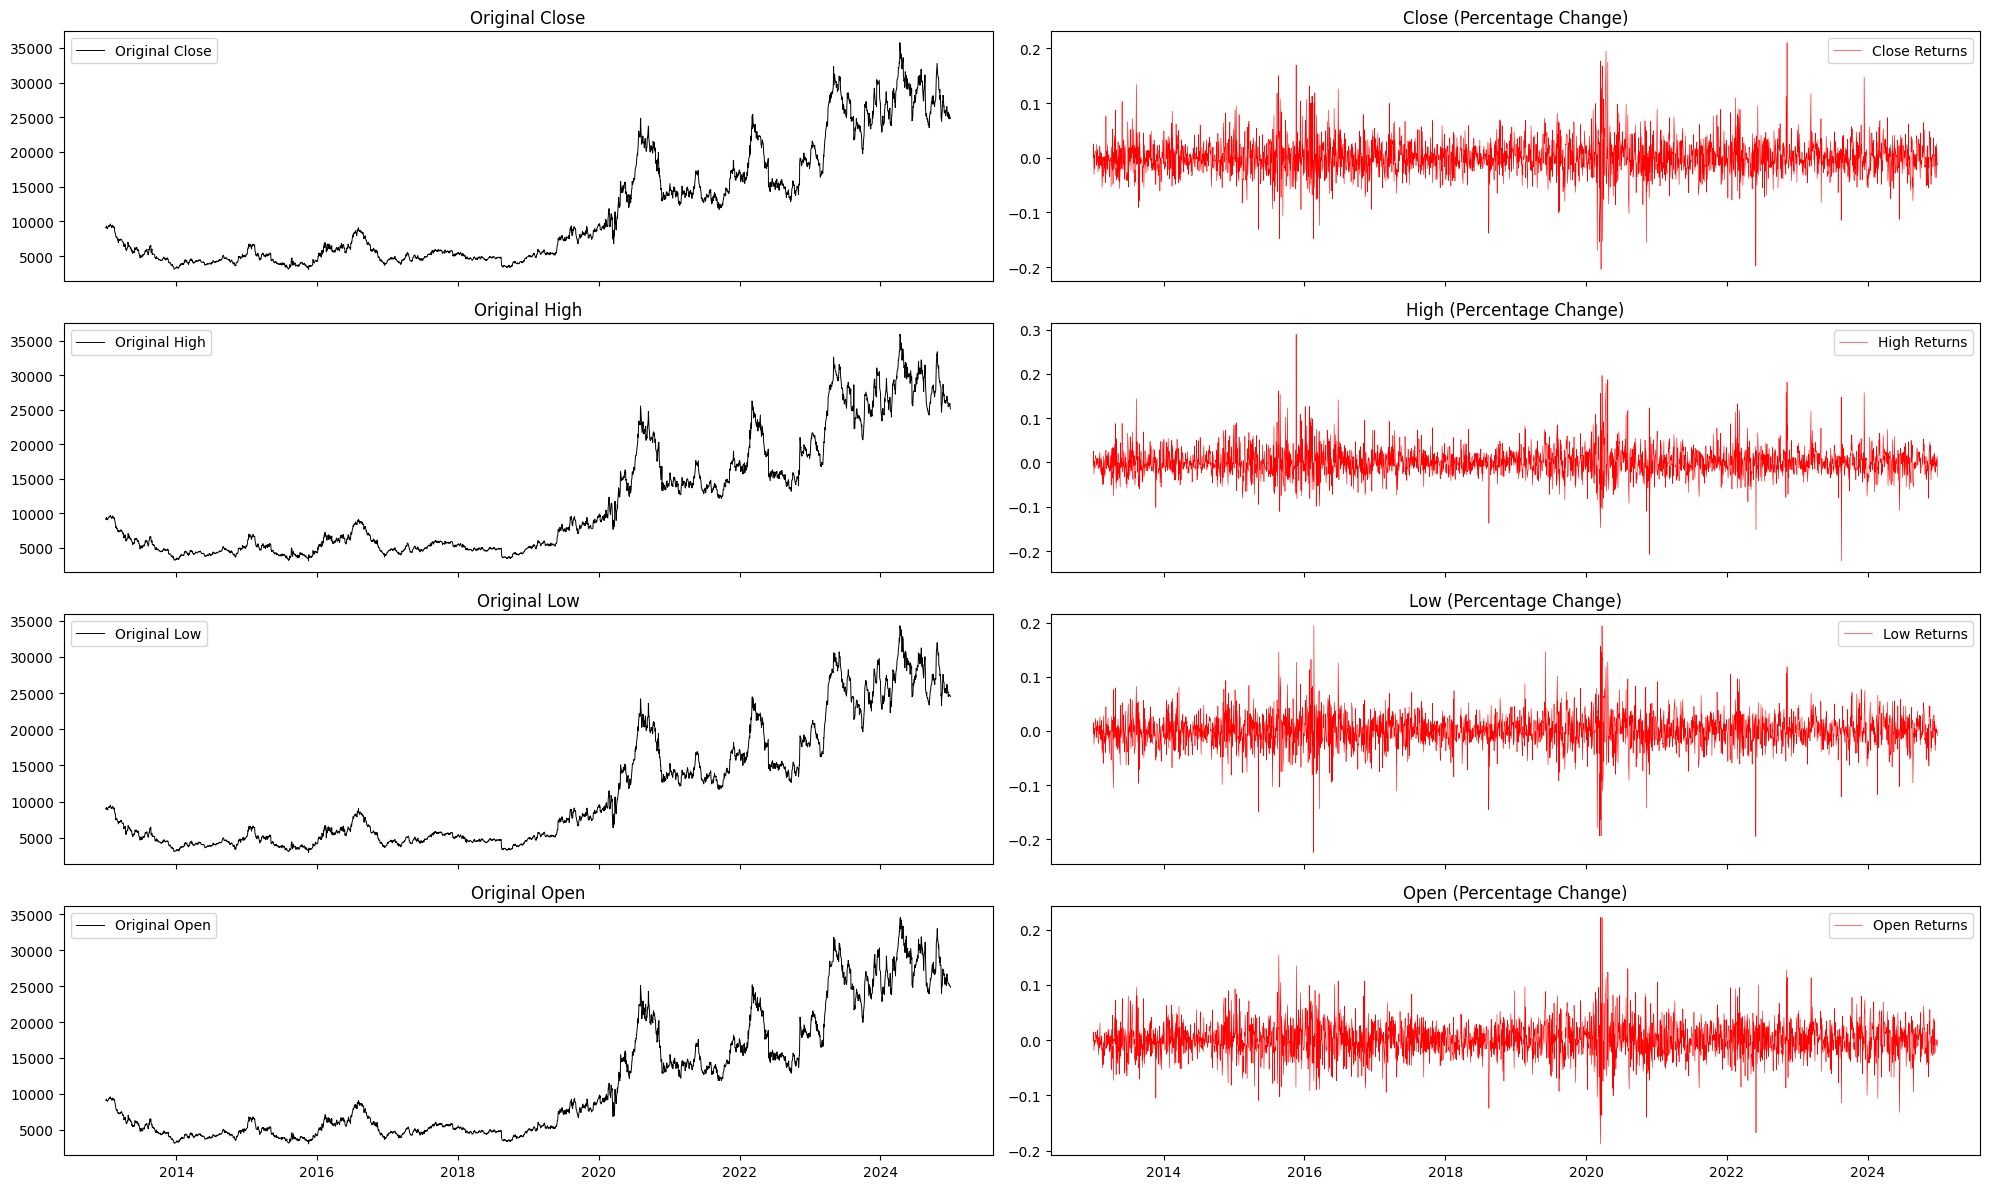

In [5]:
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(20, 3*n_features), sharex=True)

for i, col in enumerate(features):
    # Plot original in black, thin line
    axes[i, 0].plot(data1[col], label=f"Original {col}", color='black', linewidth=0.7)
    axes[i, 0].set_title(f"Original {col}")
    axes[i, 0].legend()

    # Plot returns in red, thin line
    axes[i, 1].plot(data_returns[col], label=f"{col} Returns", color='red', linewidth=0.4)
    axes[i, 1].set_title(f"{col} (Percentage Change)")
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

# Same split but different naming of train/test set

SVR

In [8]:
from sklearn.preprocessing import StandardScaler

train_SVR = data_returns[data_returns.index < "2023-01-01"]
test_SVR = data_returns[data_returns.index >= "2023-01-01"]

X_train_SVR = train_SVR[["High", "Low", "Open"]]
y_train_SVR = train_SVR["Close"]

X_test_SVR = test_SVR[["High", "Low", "Open"]]
y_test_SVR = test_SVR["Close"]

print("Before scaling (SVR):")
print("Train shape (SVR):", X_train_SVR.shape, y_train_SVR.shape)
print("Test shape (SVR):", X_test_SVR.shape, y_test_SVR.shape)

scaler_SVR = StandardScaler()

X_train_scaled_SVR = scaler_SVR.fit_transform(X_train_SVR)
X_test_scaled_SVR = scaler_SVR.transform(X_test_SVR)

print("\nAfter scaling (SVR):")
print("X_train_scaled shape (SVR):", X_train_scaled_SVR.shape)
print("X_test_scaled shape (SVR):", X_test_scaled_SVR.shape)


Before scaling (SVR):
Train shape (SVR): (2551, 3) (2551,)
Test shape (SVR): (497, 3) (497,)

After scaling (SVR):
X_train_scaled shape (SVR): (2551, 3)
X_test_scaled shape (SVR): (497, 3)


In [13]:
X_scaler_SVR = StandardScaler()
y_scaler_SVR = StandardScaler()

X_train_scaled_SVR = X_scaler_SVR.fit_transform(X_train_SVR)
X_test_scaled_SVR = X_scaler_SVR.transform(X_test_SVR)

y_train_scaled_SVR = y_scaler_SVR.fit_transform(y_train_SVR.values.reshape(-1, 1)).ravel()

svr_model = SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.01)
svr_model.fit(X_train_scaled_SVR, y_train_scaled_SVR)

y_pred_scaled_SVR = svr_model.predict(X_test_scaled_SVR)

y_pred_SVR = y_scaler_SVR.inverse_transform(y_pred_scaled_SVR.reshape(-1, 1)).ravel()

KNN

In [14]:
train_KNN = data_returns[data_returns.index < "2023-01-01"]
test_KNN = data_returns[data_returns.index >= "2023-01-01"]

X_train_KNN = train_KNN[["High", "Low", "Open"]]
y_train_KNN = train_KNN["Close"]

X_test_KNN = test_KNN[["High", "Low", "Open"]]
y_test_KNN = test_KNN["Close"]

print("Train shape (KNN):", X_train_KNN.shape, y_train_KNN.shape)
print("Test shape (KNN):", X_test_KNN.shape, y_test_KNN.shape)


Train shape (KNN): (2551, 3) (2551,)
Test shape (KNN): (497, 3) (497,)


RFR

In [15]:
from sklearn.preprocessing import StandardScaler

train_RFR = data_returns[data_returns.index < "2023-01-01"]
test_RFR = data_returns[data_returns.index >= "2023-01-01"]

X_train_RFR = train_RFR[["High", "Low", "Open"]]
y_train_RFR = train_RFR["Close"]

X_test_RFR = test_RFR[["High", "Low", "Open"]]
y_test_RFR = test_RFR["Close"]

print("Before scaling (RFR):")
print("Train shape (RFR):", X_train_RFR.shape, y_train_RFR.shape)
print("Test shape (RFR):", X_test_RFR.shape, y_test_RFR.shape)

scaler_RFR = StandardScaler()

X_train_scaled_RFR = scaler_RFR.fit_transform(X_train_RFR)
X_test_scaled_RFR = scaler_RFR.transform(X_test_RFR)

print("\nAfter scaling (RFR):")
print("X_train_scaled shape (RFR):", X_train_scaled_RFR.shape)
print("X_test_scaled shape (RFR):", X_test_scaled_RFR.shape)


Before scaling (RFR):
Train shape (RFR): (2551, 3) (2551,)
Test shape (RFR): (497, 3) (497,)

After scaling (RFR):
X_train_scaled shape (RFR): (2551, 3)
X_test_scaled shape (RFR): (497, 3)


XGBOOST

In [16]:
from sklearn.preprocessing import StandardScaler

# ===============================
# Train-Test Split (XGB)
# ===============================
train_XGB = data_returns[data_returns.index < "2023-01-01"]
test_XGB = data_returns[data_returns.index >= "2023-01-01"]

# Features (X) and Target (y)
X_train_XGB = train_XGB[["High", "Low", "Open"]]
y_train_XGB = train_XGB["Close"]

X_test_XGB = test_XGB[["High", "Low", "Open"]]
y_test_XGB = test_XGB["Close"]

print("Before scaling (XGB):")
print("Train shape (XGB):", X_train_XGB.shape, y_train_XGB.shape)
print("Test shape (XGB):", X_test_XGB.shape, y_test_XGB.shape)

# ===============================
# Scaling (XGB)
# ===============================
scaler_XGB = StandardScaler()

X_train_scaled_XGB = scaler_XGB.fit_transform(X_train_XGB)
X_test_scaled_XGB = scaler_XGB.transform(X_test_XGB)

print("\nAfter scaling (XGB):")
print("X_train_scaled shape (XGB):", X_train_scaled_XGB.shape)
print("X_test_scaled shape (XGB):", X_test_scaled_XGB.shape)

Before scaling (XGB):
Train shape (XGB): (2551, 3) (2551,)
Test shape (XGB): (497, 3) (497,)

After scaling (XGB):
X_train_scaled shape (XGB): (2551, 3)
X_test_scaled shape (XGB): (497, 3)


# Models training

In [17]:
# KNN Model

knn_model_KNN = KNeighborsRegressor(n_neighbors=5)  # you can tune n_neighbors later
knn_model_KNN.fit(X_train_KNN, y_train_KNN)

y_pred_KNN = knn_model_KNN.predict(X_test_KNN)


In [18]:
#SVR model

svr_model_SVR = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model_SVR.fit(X_train_scaled_SVR, y_train_scaled_SVR)

y_pred_scaled_SVR = svr_model_SVR.predict(X_test_scaled_SVR)

y_pred_SVR = y_scaler_SVR.inverse_transform(y_pred_scaled_SVR.reshape(-1, 1)).ravel()


In [19]:
# Random Forest model

rf_model_RFR = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_RFR.fit(X_train_scaled_RFR, y_train_RFR)

y_pred_RFR = rf_model_RFR.predict(X_test_scaled_RFR)

In [20]:
# XGBoost Regression Model

# Initialise and fit model
xgb_model_XGB = XGBRegressor(n_estimators=100, random_state=42)  # you can tune hyperparameters later
xgb_model_XGB.fit(X_train_scaled_XGB, y_train_XGB)

y_pred_XGB = xgb_model_XGB.predict(X_test_scaled_XGB)

In [21]:
# Helper function for metrics

def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = (100/len(y_true)) * np.sum(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )
    r2 = r2_score(y_true, y_pred)

    return {
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE%": mape,
        "SMAPE%": smape,
        "R²": r2
    }

# Train and evaluate models

results = []

# 1. KNN
knn_model_KNN = KNeighborsRegressor(n_neighbors=5)
knn_model_KNN.fit(X_train_KNN, y_train_KNN)
y_pred_KNN = knn_model_KNN.predict(X_test_KNN)
results.append(evaluate_model(y_test_KNN, y_pred_KNN, "KNN"))

# 2. SVR (assumes scaling already done: X_train_scaled_SVR, X_test_scaled_SVR, y_scaler_SVR)
svr_model_SVR = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model_SVR.fit(X_train_scaled_SVR, y_train_scaled_SVR)
y_pred_scaled_SVR = svr_model_SVR.predict(X_test_scaled_SVR)
y_pred_SVR = y_scaler_SVR.inverse_transform(y_pred_scaled_SVR.reshape(-1, 1)).ravel()
results.append(evaluate_model(y_test_SVR, y_pred_SVR, "SVR"))

# 3. Random Forest
rf_model_RFR = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_RFR.fit(X_train_scaled_RFR, y_train_RFR)
y_pred_RFR = rf_model_RFR.predict(X_test_scaled_RFR)
results.append(evaluate_model(y_test_RFR, y_pred_RFR, "RFR"))

# 4. XGBoost
xgb_model_XGB = XGBRegressor(n_estimators=100, random_state=42)
xgb_model_XGB.fit(X_train_scaled_XGB, y_train_XGB)
y_pred_XGB = xgb_model_XGB.predict(X_test_scaled_XGB)
results.append(evaluate_model(y_test_XGB, y_pred_XGB, "XGB"))
results_df_XGB = pd.DataFrame(results)
display(results_df_XGB)



,Model,RMSE,MAE,MAPE%,SMAPE%,R²
0,KNN,0.016815,0.012291,173.031343,93.633567,0.640732
1,SVR,0.015413,0.011377,176.732016,90.327047,0.698155
2,RFR,0.017814,0.012194,173.439139,91.439773,0.596760
3,XGB,0.019288,0.013302,209.965748,95.083838,0.527282


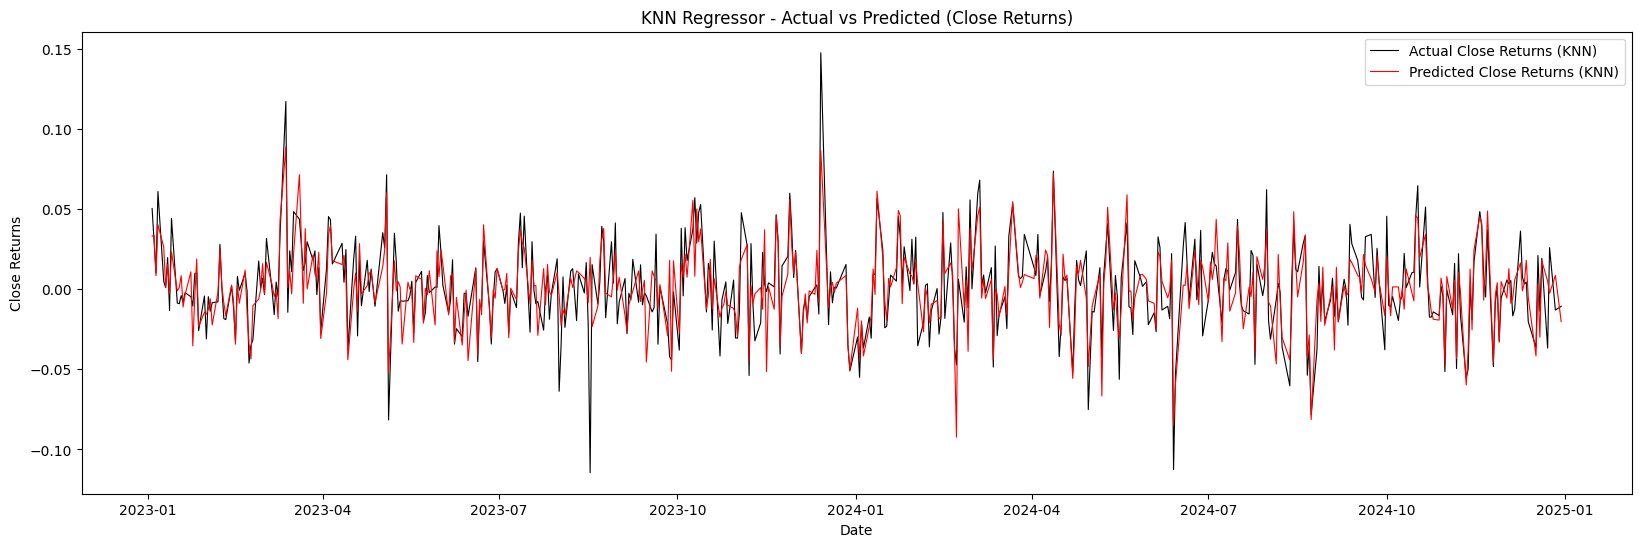

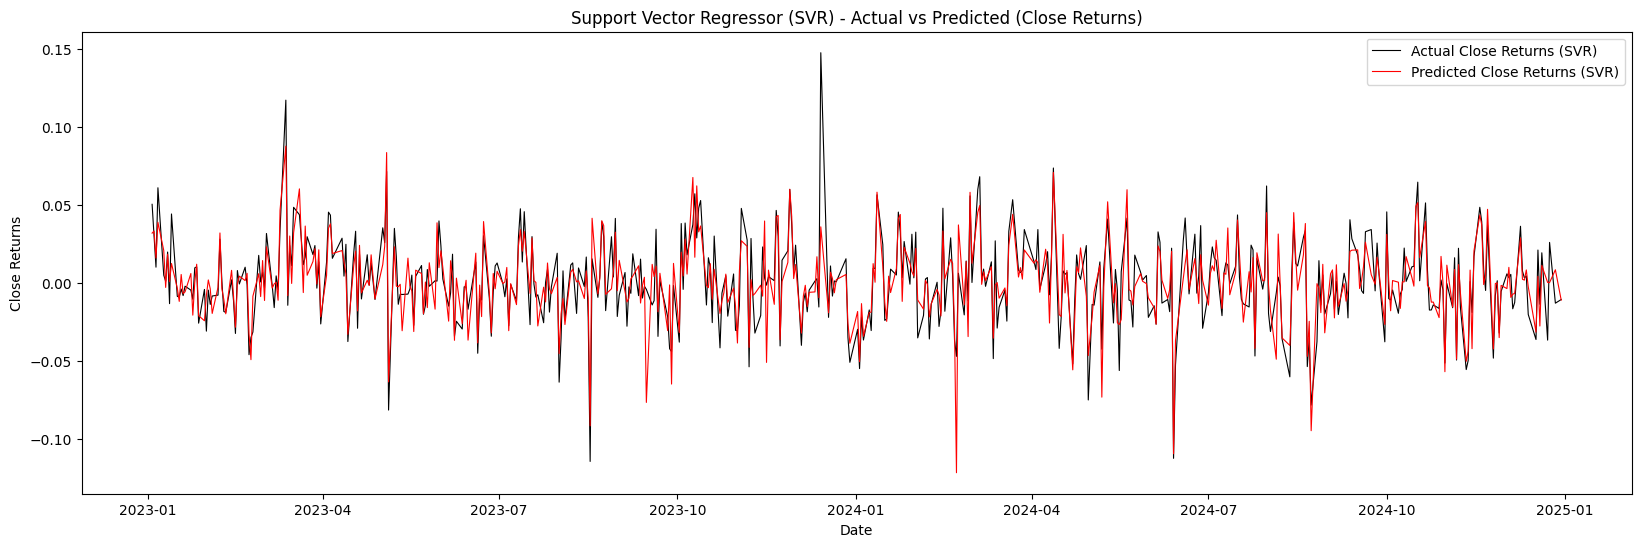

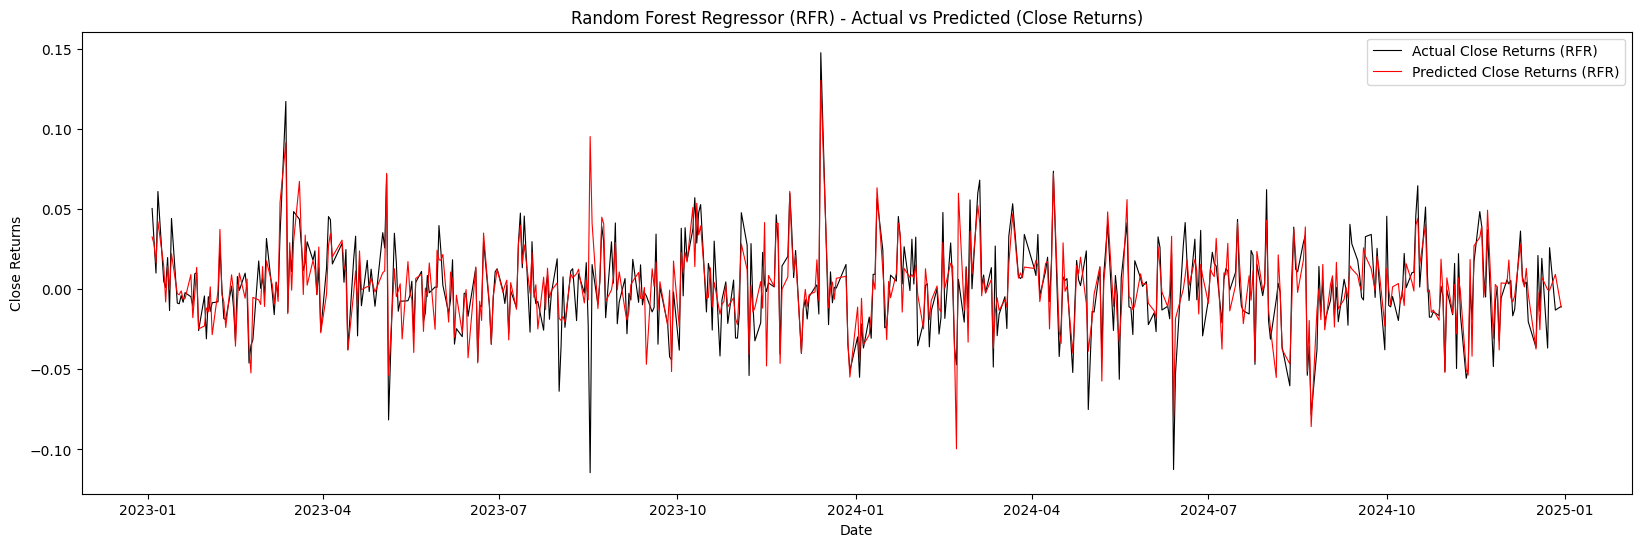

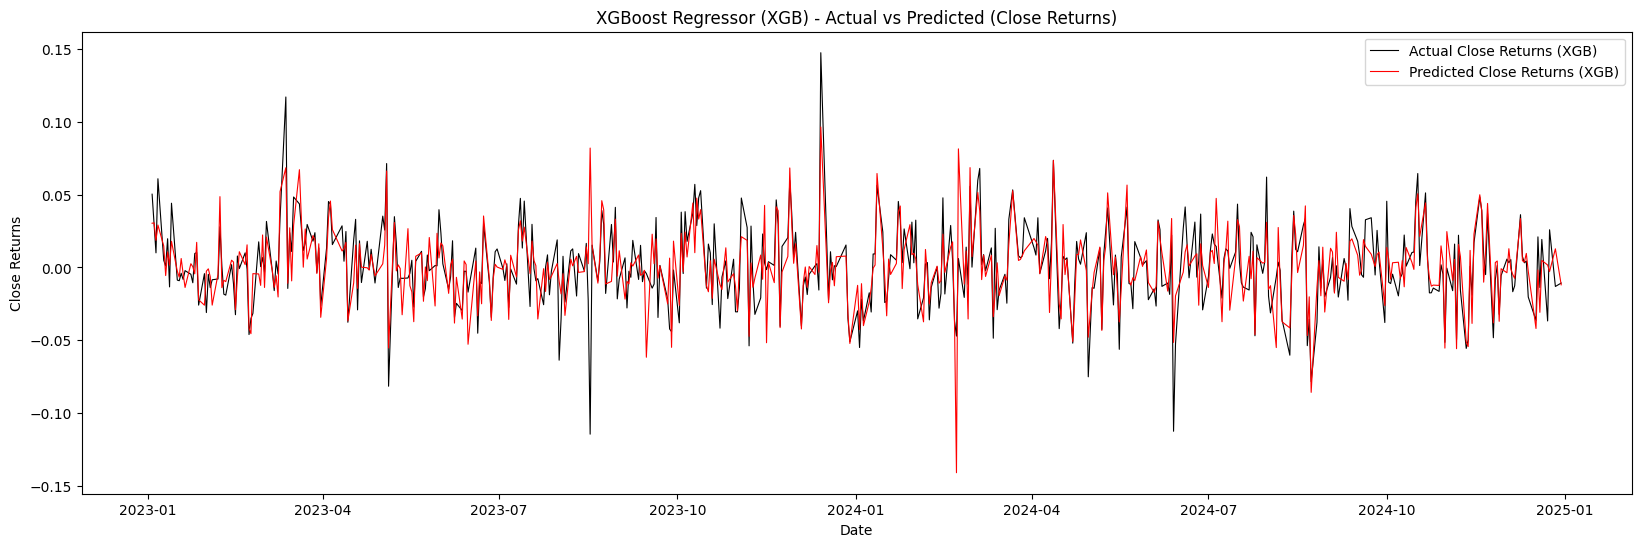

In [22]:
# KNN
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(y_test_KNN.index, y_test_KNN,
         label="Actual Close Returns (KNN)",
         color="black", linewidth=0.8)
plt.plot(y_test_KNN.index, y_pred_KNN,
         label="Predicted Close Returns (KNN)",
         color="red", linewidth=0.8)
plt.title("KNN Regressor - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

# SVR
plt.figure(figsize=(20, 6))
plt.plot(y_test_SVR.index, y_test_SVR,
         label="Actual Close Returns (SVR)",
         color="black", linewidth=0.8)
plt.plot(y_test_SVR.index, y_pred_SVR,
         label="Predicted Close Returns (SVR)",
         color="red", linewidth=0.8)
plt.title("Support Vector Regressor (SVR) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


#RFR
plt.figure(figsize=(20, 6))
plt.plot(y_test_RFR.index, y_test_RFR,
         label="Actual Close Returns (RFR)",
         color="black", linewidth=0.8)
plt.plot(y_test_RFR.index, y_pred_RFR,
         label="Predicted Close Returns (RFR)",
         color="red", linewidth=0.8)
plt.title("Random Forest Regressor (RFR) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

#XGBOOST

plt.figure(figsize=(20, 6))
plt.plot(y_test_XGB.index, y_test_XGB,
         label="Actual Close Returns (XGB)",
         color="black", linewidth=0.8)
plt.plot(y_test_XGB.index, y_pred_XGB,
         label="Predicted Close Returns (XGB)",
         color="red",linewidth=0.8 )
plt.title("XGBoost Regressor (XGB) - Actual vs Predicted (Close Returns)")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


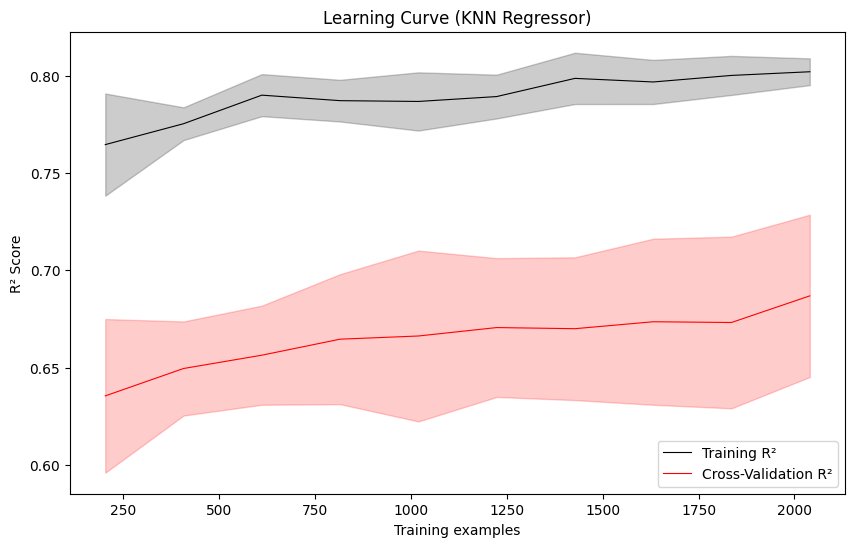

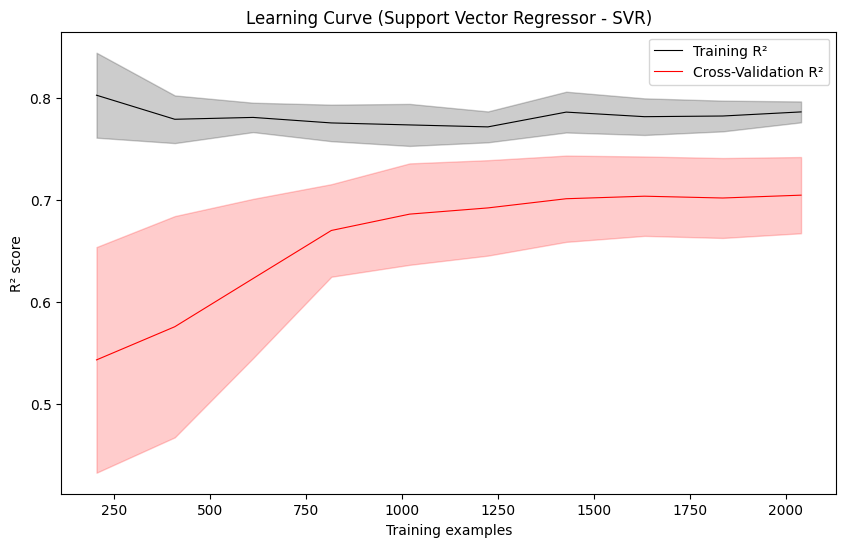

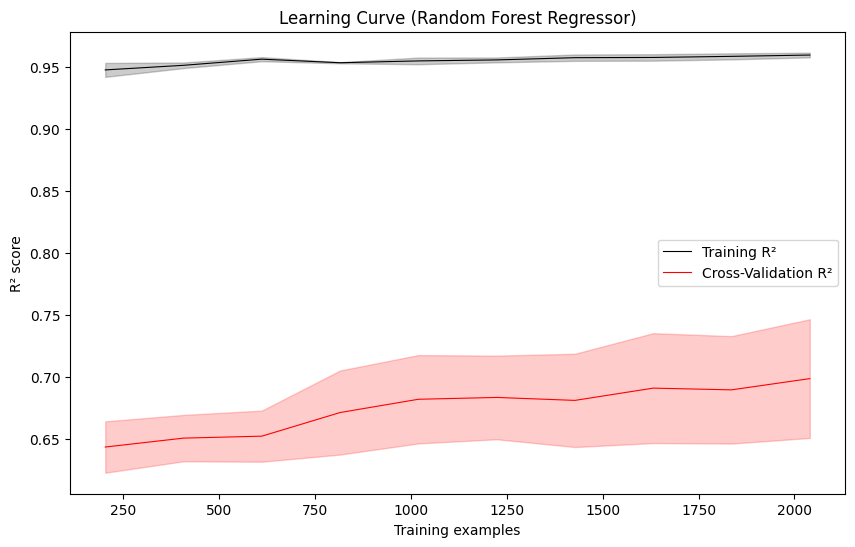

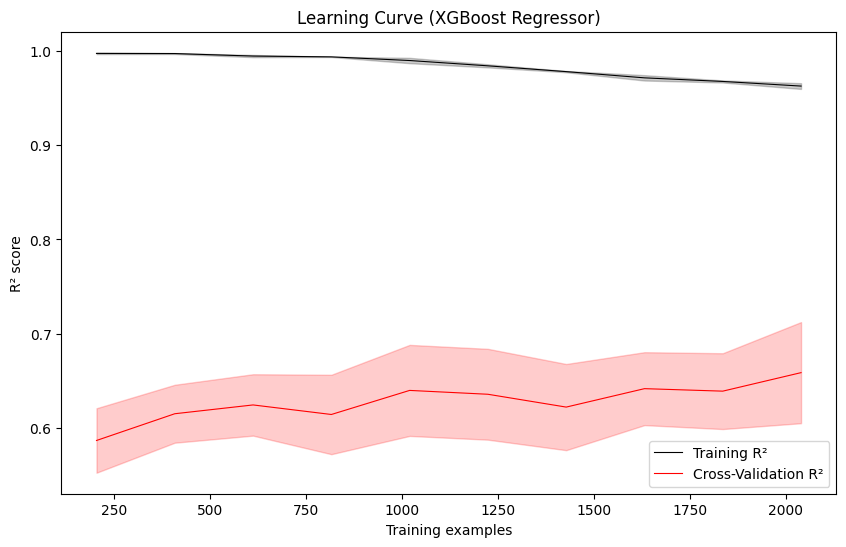

In [28]:
#KNN

knn_model = KNeighborsRegressor(n_neighbors=5)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_model,
    X=X_train_KNN,          # FIXED ✅
    y=y_train_KNN,          # FIXED ✅
    cv=5,                   # 5-fold cross-validation
    scoring="r2",           # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# Mean & std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="black", linewidth=0.8)
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="red", linewidth=0.8)

# Shaded error bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="black")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="red")

# Titles and labels
plt.title("Learning Curve (KNN Regressor)")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")

plt.show()


# SVR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=svr_model,
    X=X_train_scaled_SVR,   # use scaled X
    y=y_train_scaled_SVR,   # use scaled y
    cv=5,               # 5-fold cross validation
    scoring="r2",       # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="black", linewidth=0.8)
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="red", linewidth=0.8)

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="black")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="red")

plt.title("Learning Curve (Support Vector Regressor - SVR)")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend(loc="best")
plt.show()

# RF
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=X_train_RFR,
    y=y_train_RFR,
    cv=5,                     # 5-fold cross validation
    scoring="r2",             # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="black", linewidth=0.8)
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="red",linewidth=0.8)

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="black")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="red")

plt.title("Learning Curve (Random Forest Regressor)")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend(loc="best")

plt.show()

#XGBoost
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_model,
    X=X_train_XGB,
    y=y_train_XGB,
    cv=5,                         # 5-fold cross validation
    scoring="r2",                 # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="black", linewidth=0.8)
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="red", linewidth=0.8)

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="black")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="red")

plt.title("Learning Curve (XGBoost Regressor)")
plt.xlabel("Training examples")
plt.ylabel("R² score")
plt.legend(loc="best")
plt.show()


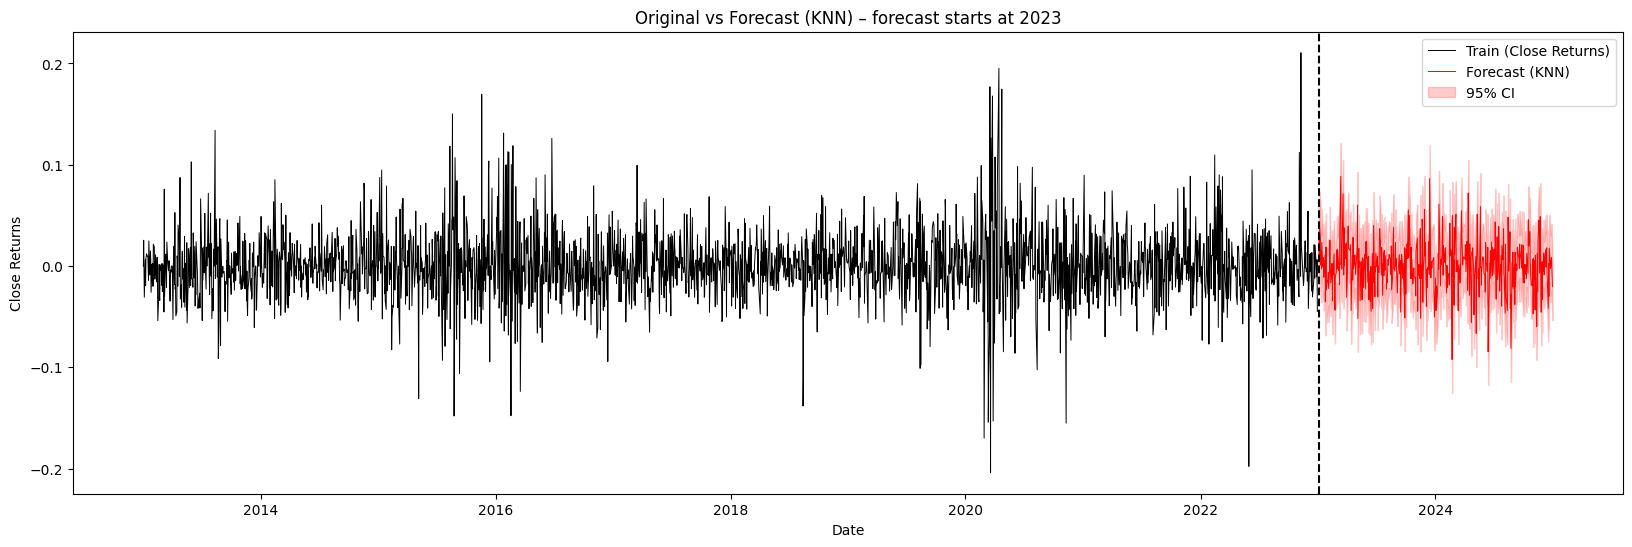

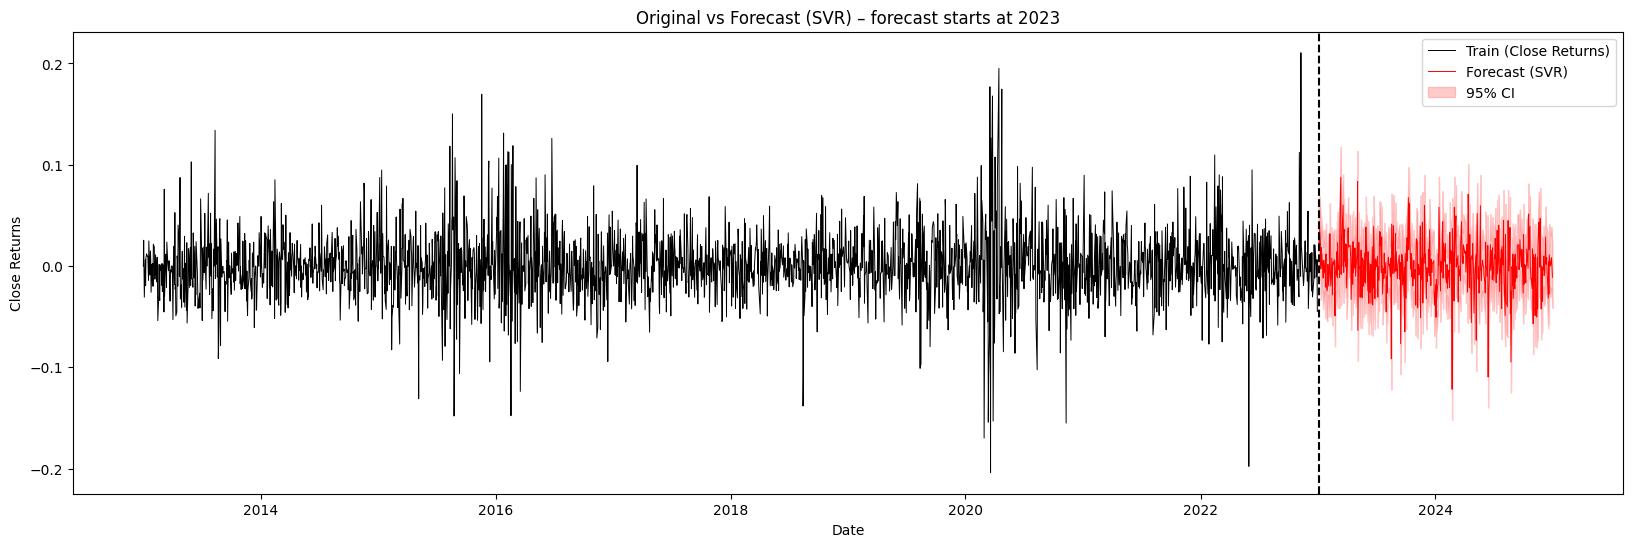

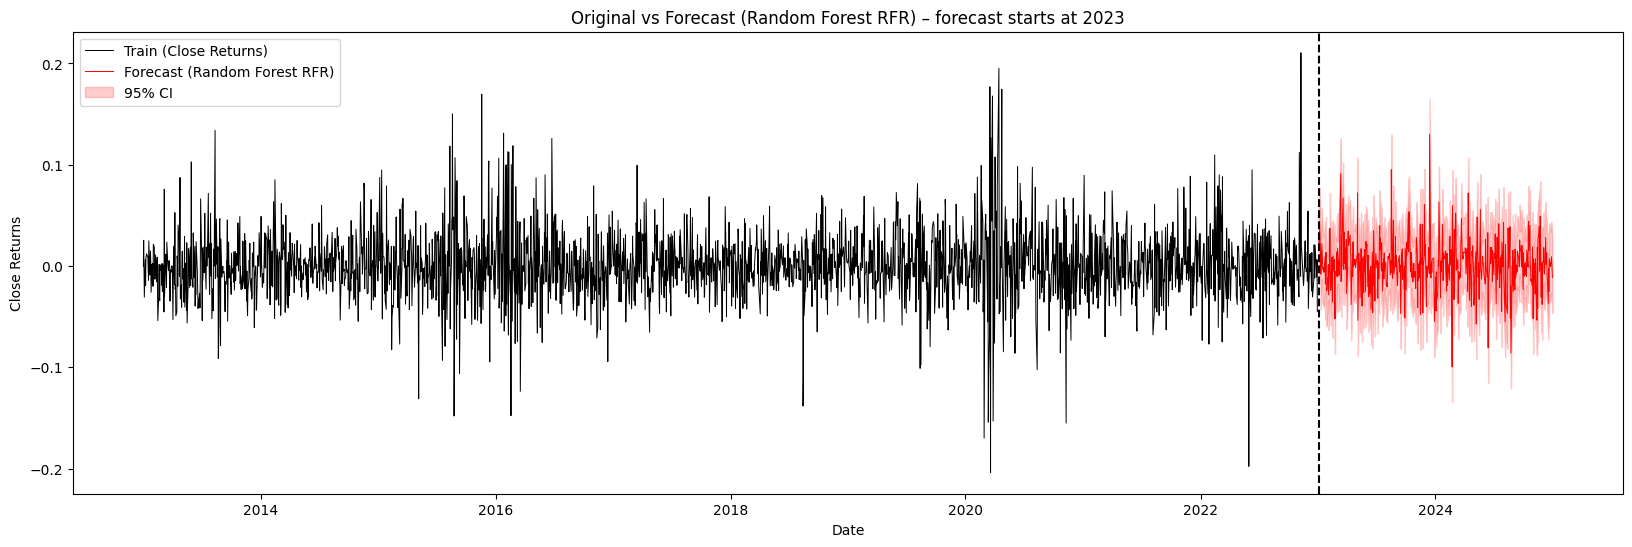

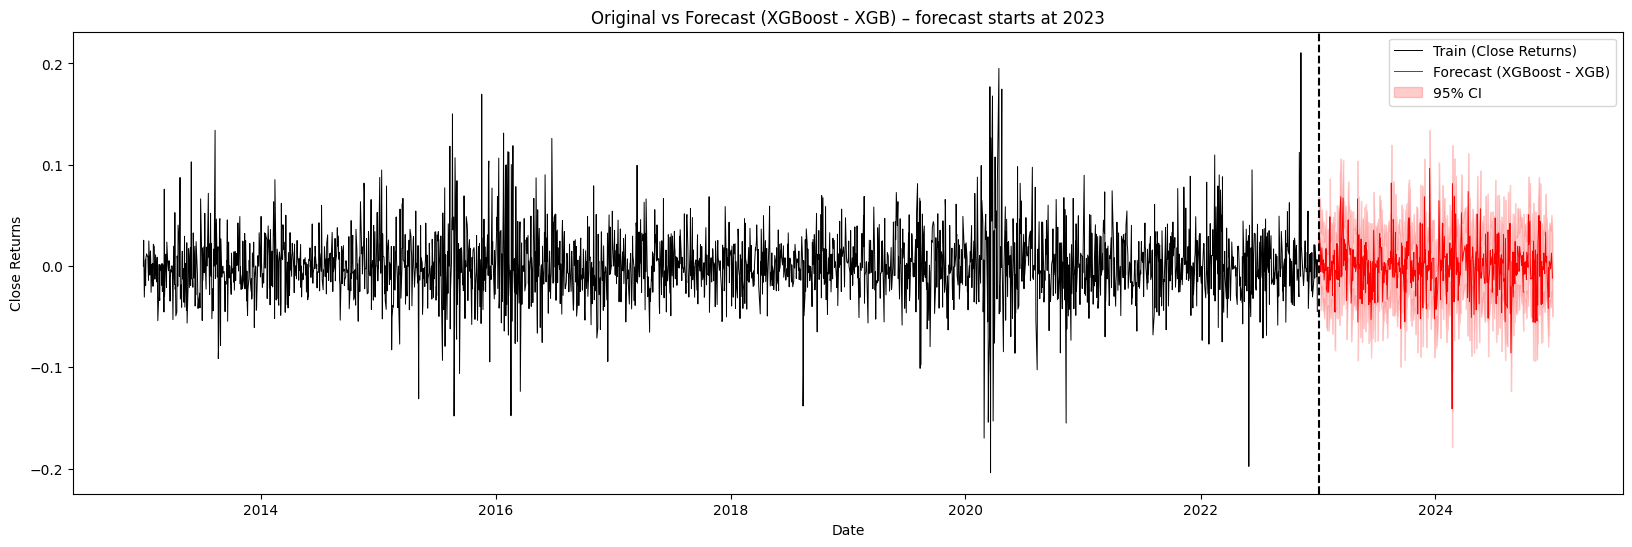

In [31]:
#KNN

error_KNN = y_test_KNN.values - y_pred_KNN
err_std_KNN = np.std(error_KNN)
lower_KNN = y_pred_KNN - 1.96 * err_std_KNN
upper_KNN = y_pred_KNN + 1.96 * err_std_KNN

plt.figure(figsize=(20, 6))

# Training data (blue) – use actual index
plt.plot(X_train_KNN.index, y_train_KNN.values, label="Train (Close Returns)", color="black", linewidth=0.7)

# Forecast (orange) – align with test index
plt.plot(y_test_KNN.index, y_pred_KNN, label="Forecast (KNN)", color="red", linewidth=0.7)

# Confidence Interval
plt.fill_between(y_test_KNN.index, lower_KNN, upper_KNN, color="red", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_KNN.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (KNN) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

#SVR
# Error and confidence interval (make sure y_pred is inverse transformed)
error_SVR = y_test_SVR.values - y_pred_SVR
err_std_SVR = np.std(error_SVR)
lower_SVR = y_pred_SVR - 1.96 * err_std_SVR
upper_SVR = y_pred_SVR + 1.96 * err_std_SVR

plt.figure(figsize=(20, 6))

# Training data (blue) – use actual index
plt.plot(X_train_SVR.index, y_train_SVR.values, label="Train (Close Returns)", color="black", linewidth=0.7)

# Forecast (orange) – align with test index
plt.plot(y_test_SVR.index, y_pred_SVR, label="Forecast (SVR)", color="red", linewidth=0.7)

# Confidence Interval
plt.fill_between(y_test_SVR.index, lower_SVR, upper_SVR, color="red", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_SVR.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (SVR) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()

#RF
# Error and confidence interval
error_RFR = y_test_RFR.values - y_pred_RFR
err_std_RFR = np.std(error_RFR)
lower_RFR = y_pred_RFR - 1.96 * err_std_RFR
upper_RFR = y_pred_RFR + 1.96 * err_std_RFR

plt.figure(figsize=(20, 6))

# Training data (blue) – use actual index
plt.plot(X_train_RFR.index, y_train_RFR.values, label="Train (Close Returns)", color="black", linewidth=0.7)

# Forecast (orange) – align with test index
plt.plot(y_test_RFR.index, y_pred_RFR, label="Forecast (Random Forest RFR)", color="red", linewidth=0.7)

# Confidence Interval
plt.fill_between(y_test_RFR.index, lower_RFR, upper_RFR, color="red", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_RFR.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (Random Forest RFR) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


#XGBOOST
# Error and confidence interval (make sure y_pred_XGB is inverse transformed if needed)
error_XGB = y_test_XGB.values - y_pred_XGB
err_std_XGB = np.std(error_XGB)
lower_XGB = y_pred_XGB - 1.96 * err_std_XGB
upper_XGB = y_pred_XGB + 1.96 * err_std_XGB

plt.figure(figsize=(20, 6))

# Training data (blue) – use actual index
plt.plot(y_train_XGB.index, y_train_XGB.values, label="Train (Close Returns)", color="black", linewidth=0.7)

# Forecast (orange) – align with test index
plt.plot(y_test_XGB.index, y_pred_XGB, label="Forecast (XGBoost - XGB)", color="red", linewidth=0.7)

# Confidence Interval
plt.fill_between(y_test_XGB.index, lower_XGB, upper_XGB, color="red", alpha=0.2, label="95% CI")

# Vertical line at boundary (start of test set)
plt.axvline(x=y_test_XGB.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (XGBoost - XGB) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


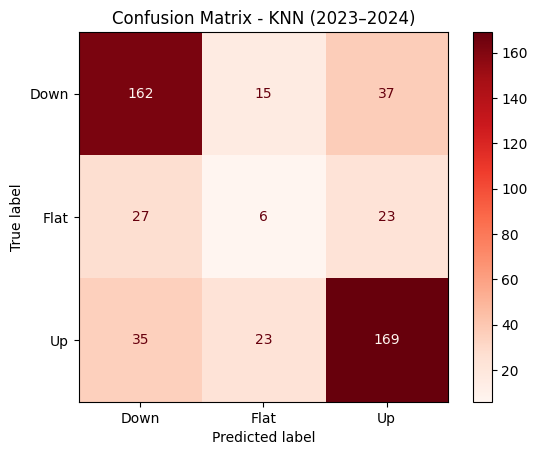

Classification Report - KNN
              precision    recall  f1-score   support

        Down       0.72      0.76      0.74       214
        Flat       0.14      0.11      0.12        56
          Up       0.74      0.74      0.74       227

    accuracy                           0.68       497
   macro avg       0.53      0.54      0.53       497
weighted avg       0.66      0.68      0.67       497



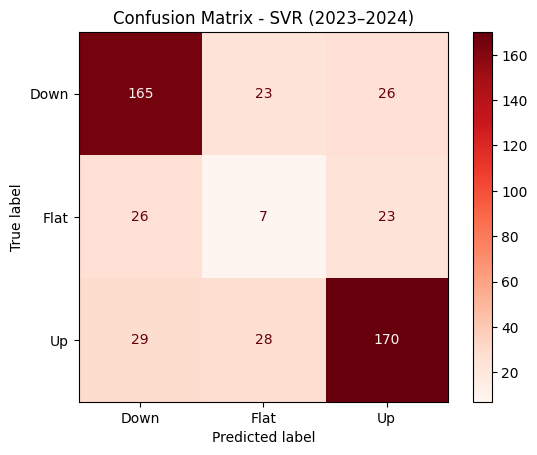

Classification Report - SVR
              precision    recall  f1-score   support

        Down       0.75      0.77      0.76       214
        Flat       0.12      0.12      0.12        56
          Up       0.78      0.75      0.76       227

    accuracy                           0.69       497
   macro avg       0.55      0.55      0.55       497
weighted avg       0.69      0.69      0.69       497



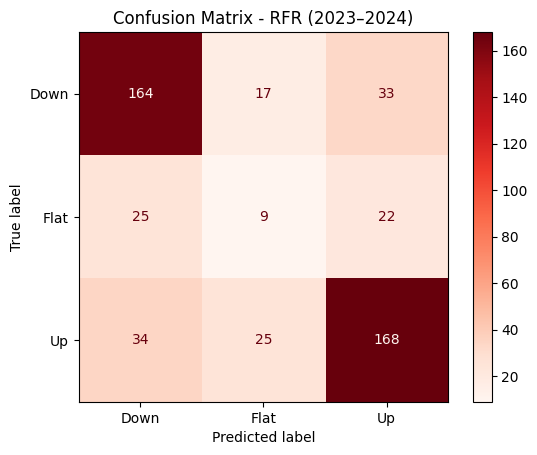

Classification Report - Random Forest (RFR)
              precision    recall  f1-score   support

        Down       0.74      0.77      0.75       214
        Flat       0.18      0.16      0.17        56
          Up       0.75      0.74      0.75       227

    accuracy                           0.69       497
   macro avg       0.56      0.56      0.56       497
weighted avg       0.68      0.69      0.68       497



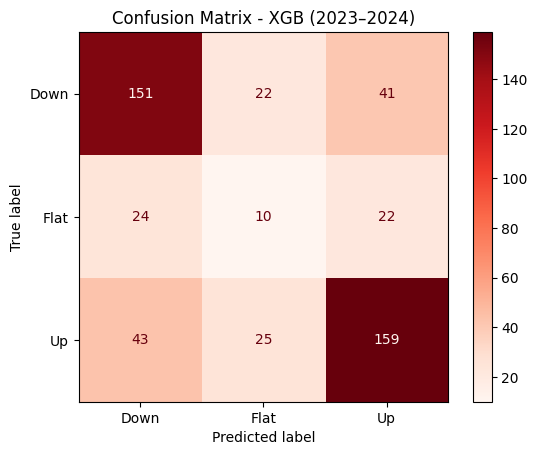

Classification Report - XGBoost (XGB)
              precision    recall  f1-score   support

        Down       0.69      0.71      0.70       214
        Flat       0.18      0.18      0.18        56
          Up       0.72      0.70      0.71       227

    accuracy                           0.64       497
   macro avg       0.53      0.53      0.53       497
weighted avg       0.65      0.64      0.64       497



In [33]:
#KNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays ---
y_test_arr_KNN = np.array(y_test_KNN).flatten()
y_pred_arr_KNN = np.array(y_pred_KNN).flatten()

# --- 2. Convert regression outputs into classes ---
def to_class_KNN(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)  # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

# --- 3. Compute daily differences ---
delta_true_KNN = np.diff(y_test_arr_KNN, prepend=y_test_arr_KNN[0])
delta_pred_KNN = np.diff(y_pred_arr_KNN, prepend=y_pred_arr_KNN[0])

# --- 4. Convert differences to classes ---
true_cls_KNN = to_class_KNN(delta_true_KNN)
pred_cls_KNN = to_class_KNN(delta_pred_KNN)

# --- 5. Confusion Matrix ---
labels_KNN = [-1, 0, 1]  # Down, Flat, Up
cm_KNN = confusion_matrix(true_cls_KNN, pred_cls_KNN, labels=labels_KNN)

disp_KNN = ConfusionMatrixDisplay(confusion_matrix=cm_KNN, display_labels=["Down", "Flat", "Up"])
disp_KNN.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - KNN (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - KNN")
print(classification_report(true_cls_KNN, pred_cls_KNN, target_names=["Down", "Flat", "Up"]))


#SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays ---
y_test_arr_SVR = np.array(y_test_SVR).flatten()
y_pred_arr_SVR = np.array(y_pred_SVR).flatten()

# --- 2. Convert regression outputs into classes ---
def to_class_SVR(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)  # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

# --- 3. Compute daily differences ---
delta_true_SVR = np.diff(y_test_arr_SVR, prepend=y_test_arr_SVR[0])
delta_pred_SVR = np.diff(y_pred_arr_SVR, prepend=y_pred_arr_SVR[0])

# --- 4. Convert differences to classes ---
true_cls_SVR = to_class_SVR(delta_true_SVR)
pred_cls_SVR = to_class_SVR(delta_pred_SVR)

# --- 5. Confusion Matrix ---
labels_SVR = [-1, 0, 1]  # Down, Flat, Up
cm_SVR = confusion_matrix(true_cls_SVR, pred_cls_SVR, labels=labels_SVR)

disp_SVR = ConfusionMatrixDisplay(confusion_matrix=cm_SVR, display_labels=["Down", "Flat", "Up"])
disp_SVR.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - SVR (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - SVR")
print(classification_report(true_cls_SVR, pred_cls_SVR, target_names=["Down", "Flat", "Up"]))

#RF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays ---
y_test_arr_RFR = np.array(y_test_RFR).flatten()
y_pred_arr_RFR = np.array(y_pred_RFR).flatten()

# --- 2. Convert regression outputs into classes ---
def to_class_RFR(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)  # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

# --- 3. Compute daily differences ---
delta_true_RFR = np.diff(y_test_arr_RFR, prepend=y_test_arr_RFR[0])
delta_pred_RFR = np.diff(y_pred_arr_RFR, prepend=y_pred_arr_RFR[0])

# --- 4. Convert differences to classes ---
true_cls_RFR = to_class_RFR(delta_true_RFR)
pred_cls_RFR = to_class_RFR(delta_pred_RFR)

# --- 5. Confusion Matrix ---
labels_RFR = [-1, 0, 1]  # Down, Flat, Up
cm_RFR = confusion_matrix(true_cls_RFR, pred_cls_RFR, labels=labels_RFR)

disp_RFR = ConfusionMatrixDisplay(confusion_matrix=cm_RFR, display_labels=["Down", "Flat", "Up"])
disp_RFR.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - RFR (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - Random Forest (RFR)")
print(classification_report(true_cls_RFR, pred_cls_RFR, target_names=["Down", "Flat", "Up"]))


#XGBOOST
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays (XGB) ---
y_test_arr_XGB = np.array(y_test_XGB).flatten()
y_pred_arr_XGB = np.array(y_pred_XGB).flatten()

# --- 2. Convert regression outputs into classes (XGB) ---
def to_class_XGB(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = Up, -1 = Down, 0 = Flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)  # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1    # Up
    cls[delta < -eps] = -1  # Down
    return cls

# --- 3. Compute daily differences (XGB) ---
delta_true_XGB = np.diff(y_test_arr_XGB, prepend=y_test_arr_XGB[0])
delta_pred_XGB = np.diff(y_pred_arr_XGB, prepend=y_pred_arr_XGB[0])

# --- 4. Convert differences to classes (XGB) ---
true_cls_XGB = to_class_XGB(delta_true_XGB)
pred_cls_XGB = to_class_XGB(delta_pred_XGB)

# --- 5. Confusion Matrix (XGB) ---
labels_XGB = [-1, 0, 1]  # Down, Flat, Up
cm_XGB = confusion_matrix(true_cls_XGB, pred_cls_XGB, labels=labels_XGB)

disp_XGB = ConfusionMatrixDisplay(confusion_matrix=cm_XGB, display_labels=["Down", "Flat", "Up"])
disp_XGB.plot(cmap="Reds", values_format="d")
plt.title("Confusion Matrix - XGB (2023–2024)")
plt.show()

# --- 6. Classification Report (XGB) ---
print("Classification Report - XGBoost (XGB)")
print(classification_report(true_cls_XGB, pred_cls_XGB, target_names=["Down", "Flat", "Up"]))


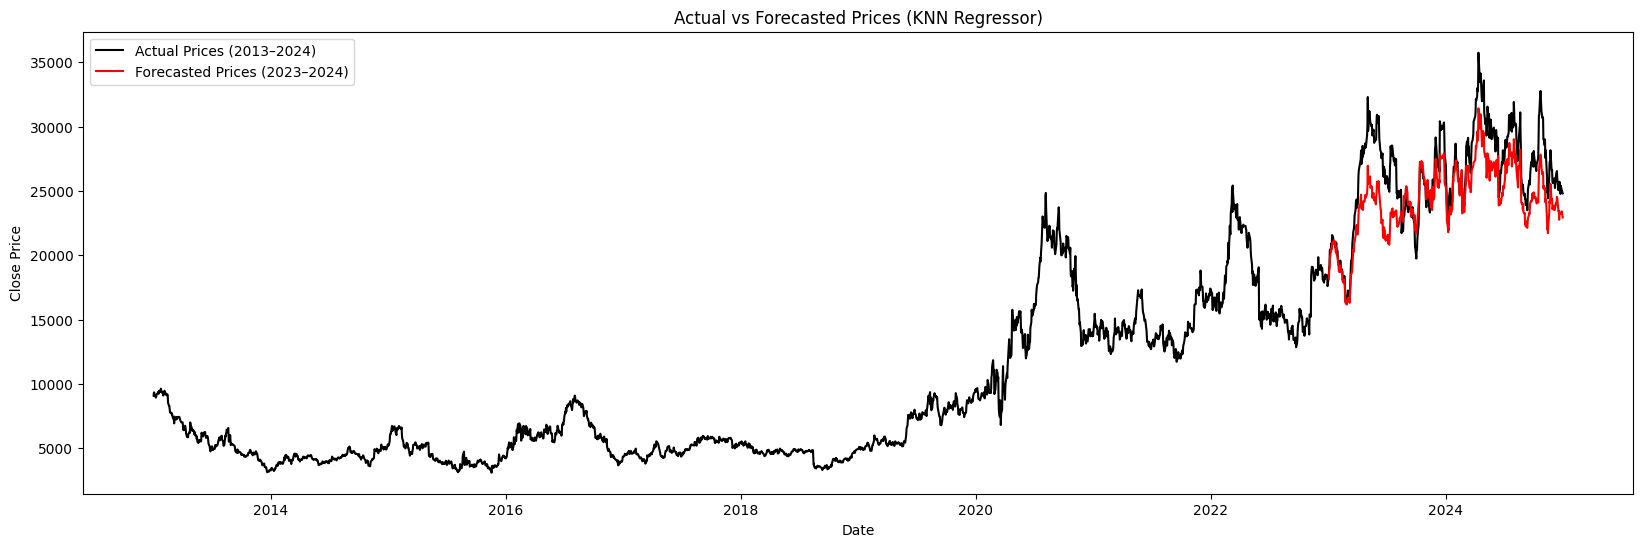

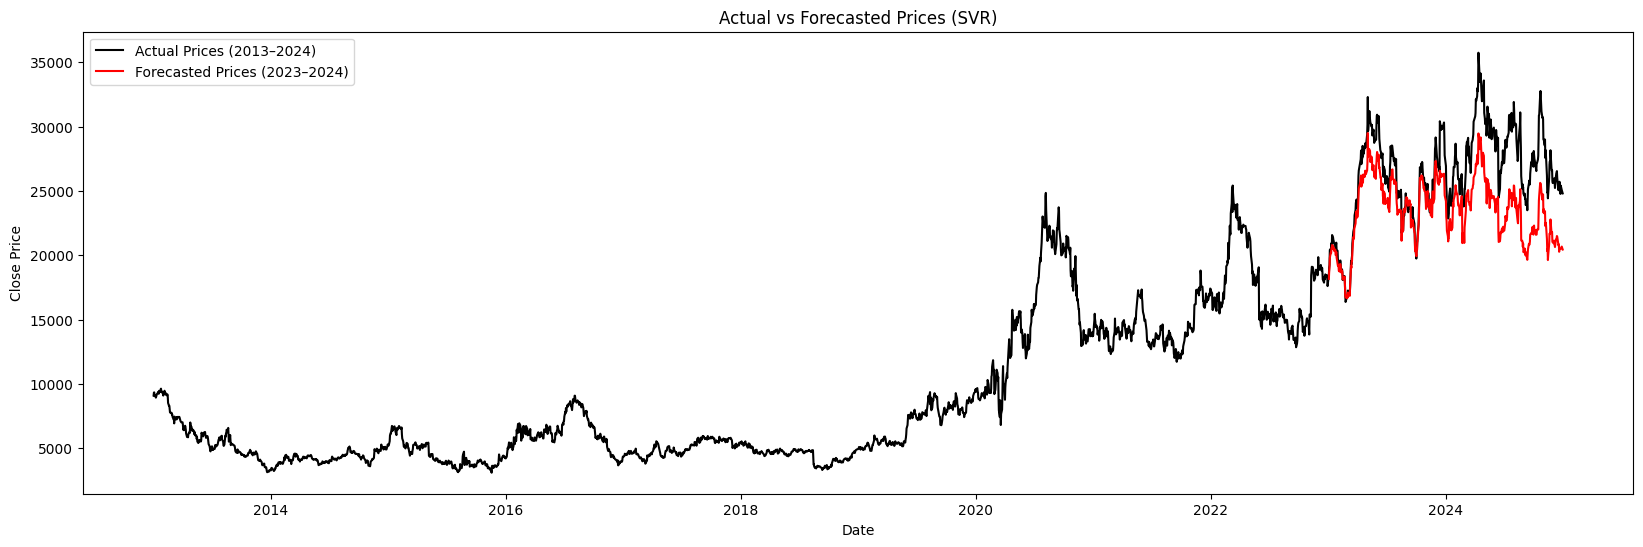

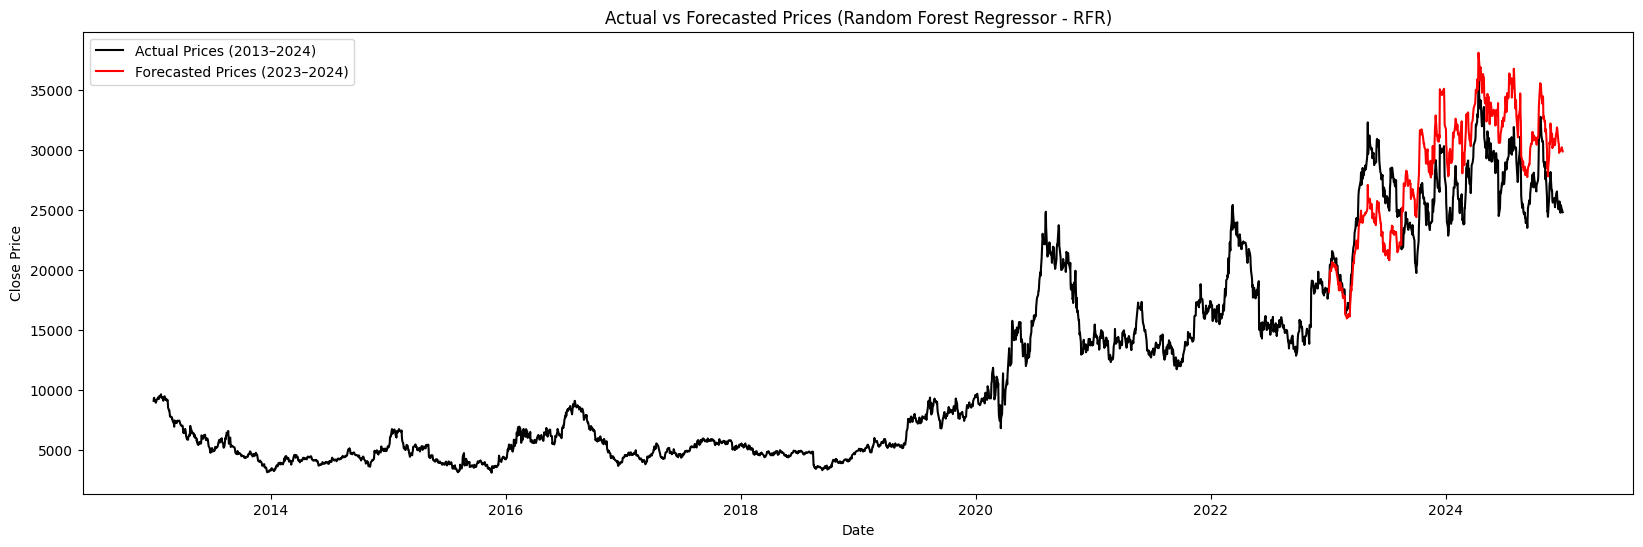

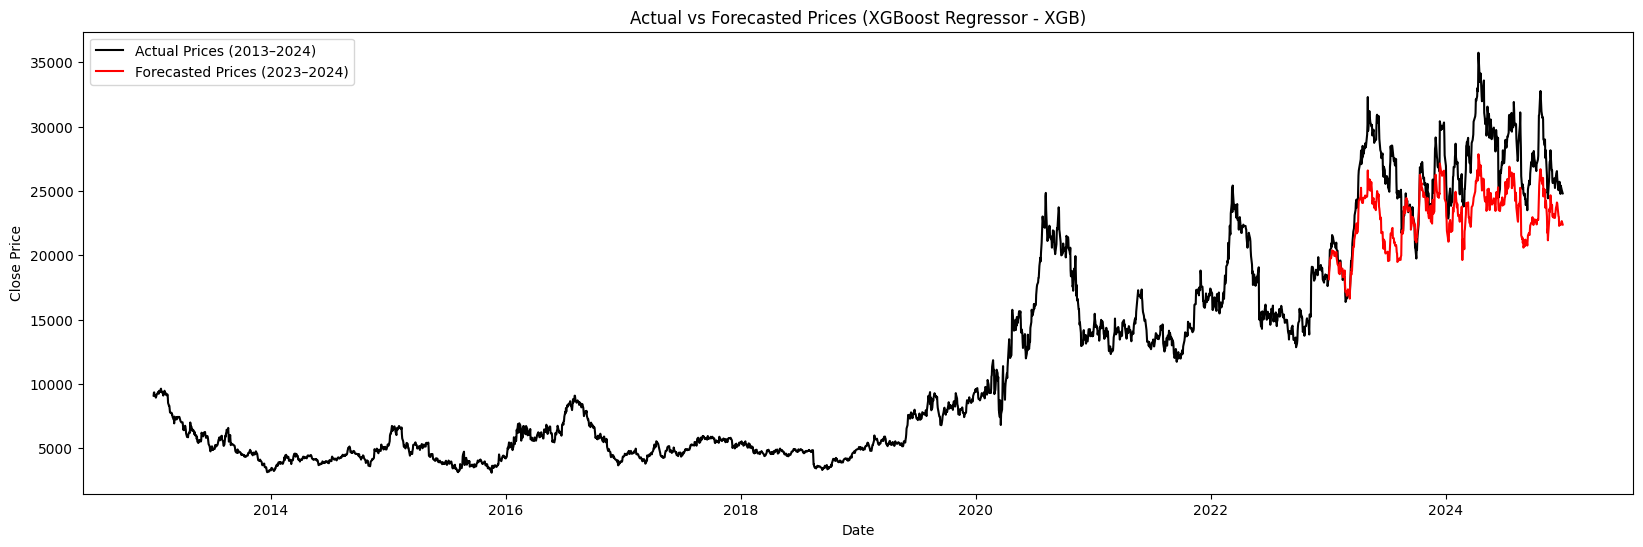

In [35]:
#KNN
P0_KNN = data1["Close"].iloc[0]  # first actual price in 2013
reconstructed_prices_KNN = (1 + data_returns["Close"]).cumprod() * P0_KNN

last_price_2022_KNN = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]  # last actual before forecast

forecast_prices_KNN = (1 + pd.Series(y_pred_KNN, index=y_test_KNN.index)).cumprod() * last_price_2022_KNN

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

# Actual reconstructed prices
plt.plot(reconstructed_prices_KNN.index, reconstructed_prices_KNN,
         label="Actual Prices (2013–2024)", color="black")

# Forecasted prices
plt.plot(forecast_prices_KNN.index, forecast_prices_KNN,
         label="Forecasted Prices (2023–2024)", color="red")

plt.title("Actual vs Forecasted Prices (KNN Regressor)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


#SVR
p0_SVR = data1["Close"].iloc[0]  # first actual price in 2013
reconstructed_prices_SVR = (1 + data_returns["Close"]).cumprod() * p0_SVR

last_price_2022_SVR = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]  # last actual before forecast

forecast_prices_SVR = (1 + pd.Series(y_pred_SVR, index=y_test_SVR.index)).cumprod() * last_price_2022_SVR

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

# Actual reconstructed prices
plt.plot(reconstructed_prices_SVR.index, reconstructed_prices_SVR,
         label="Actual Prices (2013–2024)", color="black")

# Forecasted prices
plt.plot(forecast_prices_SVR.index, forecast_prices_SVR,
         label="Forecasted Prices (2023–2024)", color="red")

plt.title("Actual vs Forecasted Prices (SVR)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#RF

P0_RFR = data1["Close"].iloc[0]  # first actual price in 2013
reconstructed_prices_RFR = (1 + data_returns["Close"]).cumprod() * P0_RFR

last_price_2022_RFR = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]  # last actual before forecast

forecast_prices_RFR = (1 + pd.Series(y_pred_RFR, index=y_test_RFR.index)).cumprod() * last_price_2022_RFR

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

# Actual reconstructed prices
plt.plot(reconstructed_prices_RFR.index, reconstructed_prices_RFR,
         label="Actual Prices (2013–2024)", color="black")

# Forecasted prices
plt.plot(forecast_prices_RFR.index, forecast_prices_RFR,
         label="Forecasted Prices (2023–2024)", color="red")

plt.title("Actual vs Forecasted Prices (Random Forest Regressor - RFR)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


#XGBOOST

P0_XGB = data1["Close"].iloc[0]  # first actual price in 2013
reconstructed_prices_XGB = (1 + data_returns["Close"]).cumprod() * P0_XGB

last_price_2022_XGB = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]  # last actual before forecast

forecast_prices_XGB = (1 + pd.Series(y_pred_XGB, index=y_test_XGB.index)).cumprod() * last_price_2022_XGB

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

# Actual reconstructed prices
plt.plot(reconstructed_prices_XGB.index, reconstructed_prices_XGB,
         label="Actual Prices (2013–2024)", color="black")

# Forecasted prices
plt.plot(forecast_prices_XGB.index, forecast_prices_XGB,
         label="Forecasted Prices (2023–2024)", color="red")

plt.title("Actual vs Forecasted Prices (XGBoost Regressor - XGB)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


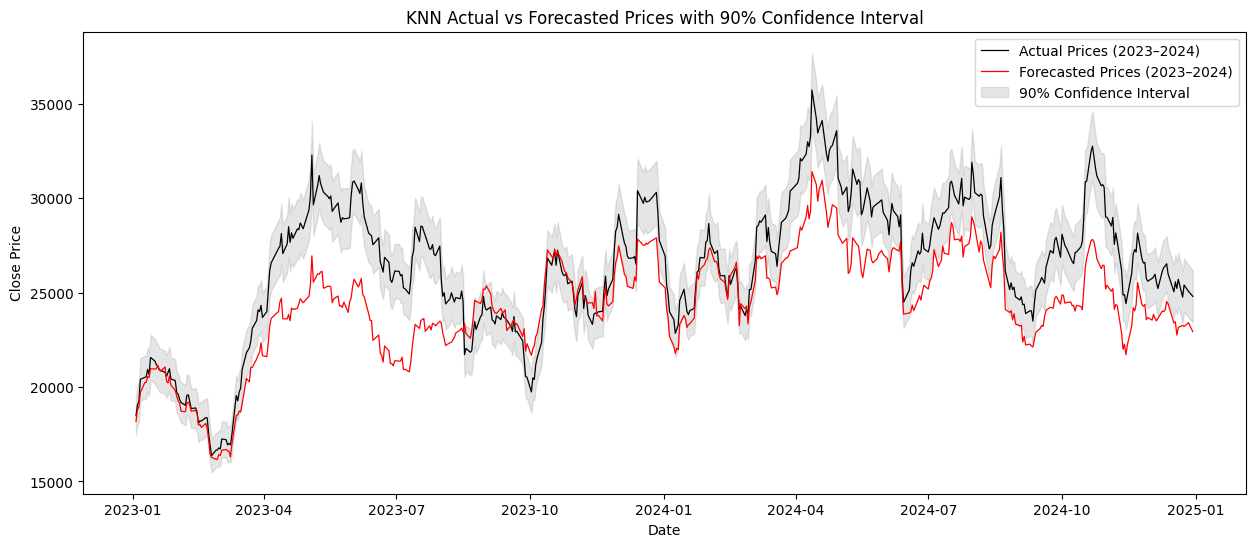

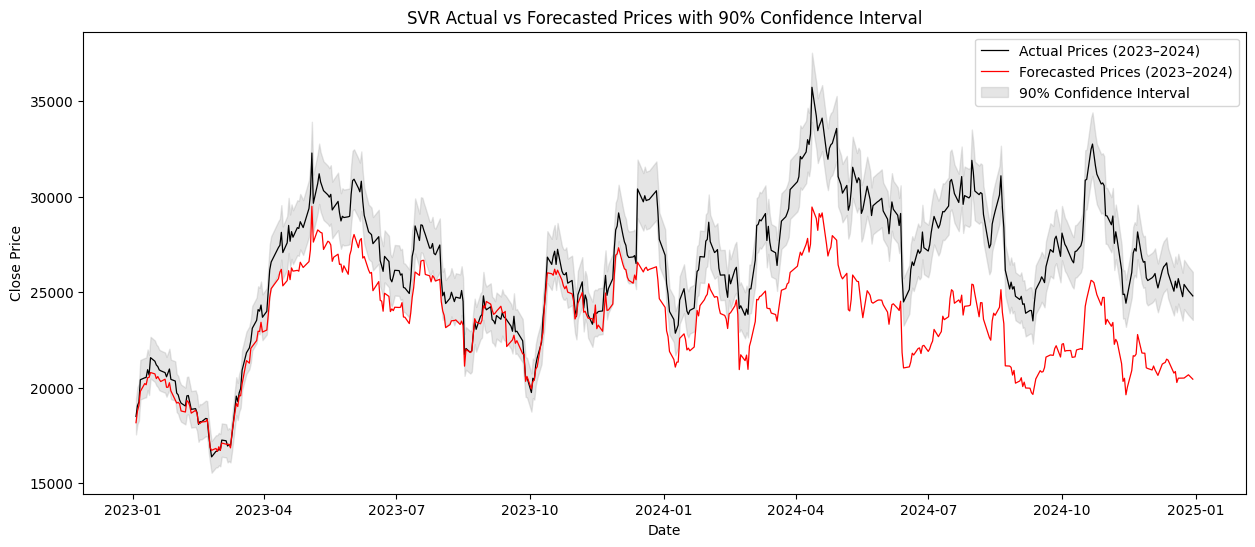

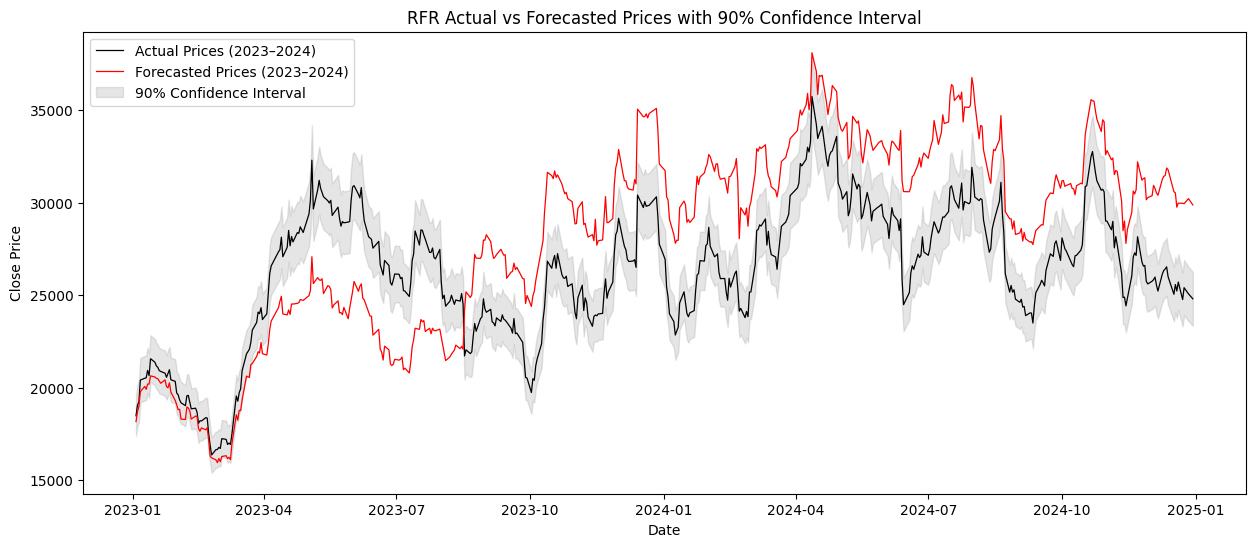

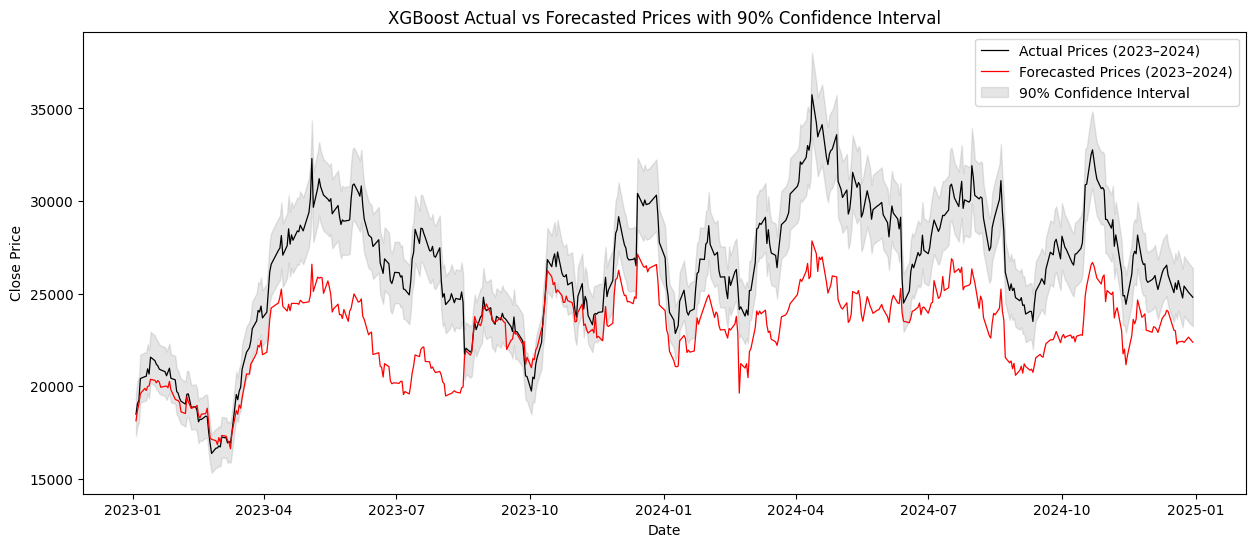

In [43]:
# KNN
# --- Residuals from test set ---
residuals_KNN = y_test_KNN - y_pred_KNN
std_resid_KNN = np.std(residuals_KNN)

# 90% Z-score
z_90 = 1.645

# Restrict actuals to forecast period
actual_trimmed_KNN = reconstructed_prices_KNN.loc[forecast_prices_KNN.index]

# Scale confidence interval as a percentage of actual prices
ci_band = z_90 * std_resid_KNN * actual_trimmed_KNN * 2   # adjust 0.05 if needed for visibility

upper_bound = actual_trimmed_KNN + ci_band
lower_bound = actual_trimmed_KNN - ci_band

plt.figure(figsize=(15, 6))

# Actual reconstructed prices
plt.plot(actual_trimmed_KNN.index, actual_trimmed_KNN,
         label="Actual Prices (2023–2024)", color="black", linewidth=0.9)

# Forecasted prices
plt.plot(forecast_prices_KNN.index, forecast_prices_KNN,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.9)

# Confidence interval shading
plt.fill_between(actual_trimmed_KNN.index,
                 lower_bound, upper_bound,
                 color="grey", alpha=0.2,
                 label="90% Confidence Interval")

plt.title("KNN Actual vs Forecasted Prices with 90% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#SVR
# --- Residuals from test set ---
residuals_SVR = y_test_SVR - y_pred_SVR
std_resid_SVR = np.std(residuals_SVR)

# 90% Z-score
z_90 = 1.645

# Restrict actuals to forecast period
actual_trimmed_SVR = reconstructed_prices_SVR.loc[forecast_prices_SVR.index]

# Scale confidence interval as a percentage of actual prices
ci_band = z_90 * std_resid_SVR * actual_trimmed_SVR * 2   # adjust 0.05 if needed for visibility

upper_bound = actual_trimmed_SVR + ci_band
lower_bound = actual_trimmed_SVR - ci_band

plt.figure(figsize=(15, 6))

# Actual reconstructed prices
plt.plot(actual_trimmed_SVR.index, actual_trimmed_SVR,
         label="Actual Prices (2023–2024)", color="black", linewidth=0.9)

# Forecasted prices
plt.plot(forecast_prices_SVR.index, forecast_prices_SVR,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.9)

# Confidence interval shading
plt.fill_between(actual_trimmed_SVR.index,
                 lower_bound, upper_bound,
                 color="grey", alpha=0.2,
                 label="90% Confidence Interval")

plt.title("SVR Actual vs Forecasted Prices with 90% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#RFR
# --- Residuals from test set ---
residuals_RFR = y_test_RFR - y_pred_RFR
std_resid_RFR = np.std(residuals_RFR)

# 90% z-score
z_90 = 1.645

# Restrict actuals to forecast period
actual_trimmed = reconstructed_prices_RFR.loc[forecast_prices_RFR.index]

# Scale confidence interval as a percentage of actual prices
ci_band = z_90 * std_resid_RFR * actual_trimmed * 2   # adjust 0.05 if needed for visibility

upper_bound = actual_trimmed + ci_band
lower_bound = actual_trimmed - ci_band

plt.figure(figsize=(15, 6))

# Actual reconstructed prices
plt.plot(actual_trimmed.index, actual_trimmed,
         label="Actual Prices (2023–2024)", color="black", linewidth=0.9)

# Forecasted prices
plt.plot(forecast_prices_RFR.index, forecast_prices_RFR,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.9)

# Confidence interval shading (same style as learning curve)
plt.fill_between(actual_trimmed.index,
                 lower_bound, upper_bound,
                 color="grey", alpha=0.2, label="90% Confidence Interval")

plt.title("RFR Actual vs Forecasted Prices with 90% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

#XGB
# --- Residuals from test set ---
residuals_XGB = y_test_XGB - y_pred_XGB
std_resid_XGB = np.std(residuals_XGB)

# 90% Z-score
z_90 = 1.645

# Restrict actuals to forecast period
actual_trimmed_XGB = reconstructed_prices_XGB.loc[forecast_prices_XGB.index]

# Scale confidence interval as a percentage of actual prices
ci_band = z_90 * std_resid_XGB * actual_trimmed_XGB * 2   # adjust 0.05 if needed for visibility

upper_bound = actual_trimmed_XGB + ci_band
lower_bound = actual_trimmed_XGB - ci_band

plt.figure(figsize=(15, 6))

# Actual reconstructed prices
plt.plot(actual_trimmed_XGB.index, actual_trimmed_XGB,
         label="Actual Prices (2023–2024)", color="black", linewidth=0.9)

# Forecasted prices
plt.plot(forecast_prices_XGB.index, forecast_prices_XGB,
         label="Forecasted Prices (2023–2024)", color="red", linewidth=0.9)

# Confidence interval shading
plt.fill_between(actual_trimmed_XGB.index,
                 lower_bound, upper_bound,
                 color="grey", alpha=0.2,
                 label="90% Confidence Interval")

plt.title("XGBoost Actual vs Forecasted Prices with 90% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
